<a href="https://colab.research.google.com/github/OIEIEIO/supreme-octo-chainsaw/blob/main/Create_Realistic_AI_Generated_Images_With_VQGAN_%2B_CLIP_%2B_ERGAN_Upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Realistic AI-Generated Images With VQGAN + CLIP + ESRGAN

by [Ray Krehn](https://www.krehnsolutions.com). 

This notebook allows you to create realistic AI generated images with as few clicks as possible for free! No coding or machine learning knowledge required!

This notebook is forked with significant usability and technical optimizations from the [original Colab notebook](https://colab.research.google.com/drive/1Foi0mCSE6NrW9oI3Fhni7158Krz4ZXdH) by [@ak92501](https://twitter.com/ak92501) which includes an implementation of VQGAN + CLIP w/ Pooling. The Notebook was originally made by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings), and [Max Woolf](https://minimaxir.com). The original BigGAN+CLIP method was by https://twitter.com/advadnoun. Added some explanations and modifications by Eleiber#8347, pooling trick by Crimeacs#8222 (https://twitter.com/EarthML1). For more elaborate customization, see the original notebook or [Zoetrope 5](https://colab.research.google.com/drive/1LpEbICv1mmta7Qqic1IcRTsRsq7UKRHM) by [@classpectanon](https://twitter.com/classpectanon). Added ESRGAN for upscaling, and additional models.

To get started:

1. Copy this notebook to your Google Drive to keep it and save your changes. (File -> Save a Copy in Drive)
2. Run the cells below by clicking the **Play** button on the left of the cell (also visible when mousing-over the cell)

_Last Updated: November 29th 2021_


## Setup
Just press the "Play" button. Don't do anything else.

In [ ]:
#@title Initialize GPU, Imports, and models
#@markdown Run this to allocation a GPU and CPU to a server. It will also install all gits and models code to build the AI.
#@markdown 

!nvidia-smi

#@title Download Models and Install/Load Packages (may take a few minutes)

!git clone https://github.com/openai/CLIP --quiet
!git clone https://github.com/CompVis/taming-transformers.git --quiet
#!git clone https://github.com/minimaxir/icon-image.git --quiet
!pip install Pillow numpy fire icon_font_to_png --quiet
!pip install ftfy regex tqdm omegaconf pytorch-lightning --quiet 
!pip install kornia --quiet
!pip install imageio-ffmpeg --quiet
!pip install einops --quiet
!pip install imagio --quiet 
!pip3 install ml4a --quiet
!mkdir steps

#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---

#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good

#@markdown T4 = Good (*preferred*)

#@markdown K80 = Nope. Terminate session and start over. 

#@markdown P4 = Big nope. Terminate session and start over. 

#@markdown ---

# import modeos
import argparse
import math
from pathlib import Path
import sys

sys.path.insert(1, '/content/taming-transformers')
#sys.path.insert(1, '/content/icon-image')

#from icon_image import gen_icon
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from PIL.PngImagePlugin import PngInfo
from taming.models import cond_transformer, vqgan
import taming.modules 
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from shutil import move
import os

from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            # K.RandomHorizontalFlip(p=0.5),
            # K.RandomVerticalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            # K.RandomSharpness(0.3,p=0.4),
            # K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5),
            # K.RandomCrop(size=(self.cut_size,self.cut_size), p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):

            # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            # offsetx = torch.randint(0, sideX - size + 1, ())
            # offsety = torch.randint(0, sideY - size + 1, ())
            # cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

            # cutout = transforms.Resize(size=(self.cut_size, self.cut_size))(input)
            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)



## AI Image Generation Settings

The following cell allows you to set the training parameters for image generation:

### Generation Settings

- `texts`: The text prompt(s) you want the AI to generate an image from.
  - You can include multiple prompts by separating them with a `|`, and the AI will attempt to optimize for all prompts simultaneously, e.g. `apple | painting of a calm sunset`
  - You can apply a weight to each prompt by appending a `:{weight}` to each prompt, and the AI will attempt to favor prompts with a higher weight proportionally more, e.g. `apple:3 | painting of a calm sunset:1`

- `width`, `height`: Width and height of the image in pixels. Smaller images generate faster but are less detailed.
  - Going too high above the default 600x600px size may result in the GPU going out-of-memory.
  - For 4:3 images, I recommend 640x480; for 16:9 images, I recommend 640x360.

### Training Settings

- `learning_rate`: Learning rate for the model which controls the speed in which the model optimizes for the prompts. If too high, model can diverge; if too low, model may not train.
  - ~0.2 is recommend if training without an `init_image`; ~0.1 is recommended if using one.

- `max_steps`: Number of steps for training the model; the more steps, the better the generation. Typically around 250 you have an idea of what the image will end up as by about 1,500 it's 95% done.

- `images_interval`: Number of steps for the training to check in and output an image of what is trained so far.

In [ ]:
# Fixed parameters
icon_path = "icon.png"
model_name = "vqgan_imagenet_f16_16384"
import random
seed = random.randint(1,100000000)

texts = "a meadow with a river in summer vs a meadow with a river in winter" #@param {type:"string"}
width =  640#@param {type:"integer"}
height =  480#@param {type:"integer"}
init_image = "" #@param {type:"string"}
init_image_icon = False 
if init_image_icon:
  assert os.path.exists(icon_path), "No icon has been generated from the previous cell"
  init_image = icon_path

target_images = "" 
target_image_icon = False 
if target_image_icon:
  assert os.path.exists(icon_path), "No icon has been generated from the previous cell"
  target_images = icon_path

max_steps =  1500#@param {type:"integer"}
images_interval =  250#@param {type:"integer"}

#these are required
# allow user to determine which images to use
#@markdown: Choose one of these models. The top three are my favorites
model_name = 'vqgan_imagenet_f16_16384' #@param ['gumbel_8192', 'vqgan_imagenet_f16_16384', 'wikiart_f16_16384_8145600', 'vqgan_imagenet_f16_1024', 'coco', 'faceshq', 'wikiart_1024', 'sflckr', 'ade20k', 'ffhq', 'celebahq'] {type:"string"}

if model_name == 'vqgan_imagenet_f16_16384': 
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if model_name == 'vqgan_imagenet_f16_1024':
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if model_name == 'gumbel_8192':
  !curl -L -o gumbel_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #Gumbel 8192
  !curl -L -o gumbel_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #Gumbel 8192
if model_name == 'coco':
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if model_name == 'faceshq':
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if model_name == 'wikiart_1024': 
  !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
  !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
if model_name == 'wikiart_f16_16384_8145600': 
  !curl -L -o wikiart_f16_16384_8145600.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_f16_16384_8145600.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if model_name == 'sflckr':
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR
if model_name == 'ade20k':
  !curl -L -o ade20k.yaml -C - 'https://static.miraheze.org/intercriaturaswiki/b/bf/Ade20k.txt' #ADE20K
  !curl -L -o ade20k.ckpt -C - 'https://app.koofr.net/content/links/0f65c2cd-7102-4550-a2bd-07fd383aac9e/files/get/last.ckpt?path=%2F2020-11-20T21-45-44_ade20k_transformer%2Fcheckpoints%2Flast.ckpt' #ADE20K
if model_name == 'ffhq':
  !curl -L -o ffhq.yaml -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/2021-04-23T18-19-01-project.yaml?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fconfigs%2F2021-04-23T18-19-01-project.yaml&force' #FFHQ
  !curl -L -o ffhq.ckpt -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/last.ckpt?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fcheckpoints%2Flast.ckpt&force' #FFHQ
if model_name == 'celebahq':
  !curl -L -o celebahq.yaml -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/2021-04-23T18-11-19-project.yaml?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fconfigs%2F2021-04-23T18-11-19-project.yaml&force' #CelebA-HQ
  !curl -L -o celebahq.ckpt -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/last.ckpt?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fcheckpoints%2Flast.ckpt&force' #CelebA-HQ

#@markdown ---
#@markdown Advanced Settings:
#learning_rate = 0.2 #@param {type:"slider", min:0.00, max:0.30, step:0.01}
#@markdown How large of an image "cut" you want where smaller requires more time. Recommended is 32
cutn = 32 #@param {type:"integer"}
#@markdown How strong you want each "image cut". Recommended is 1.
cut_pow = 1. #@param {type:"number"} 
#@markdown Learning rate where 0.1 is good for initial images and 0.3 is stronger. Recommended is 0.2
step_size = 0.2 #@param {type:"number"}

gen_config = {
    "texts": texts,
    "width": width,
    "height": height,
    "init_image": "<icon>" if init_image_icon else init_image,
    "target_images": "<icon>" if target_image_icon else target_images,
    "learning_rate": step_size,
    "max_steps": max_steps,
    "training_seed": seed, #was 42
    "model": model_name
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   692  100   692    0     0    435      0  0:00:01  0:00:01 --:--:--   435
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  10.6M      0  0:01:27  0:01:27 --:--:-- 11.4M


Using device: cuda:0
Using texts: ['a meadow with a river in summer vs a meadow with a river in winter']
Using seed: 3676840
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 333kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 174MiB/s]


  0%|          | 0/1500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


i: 0, loss: 0.970626, losses: 0.970626


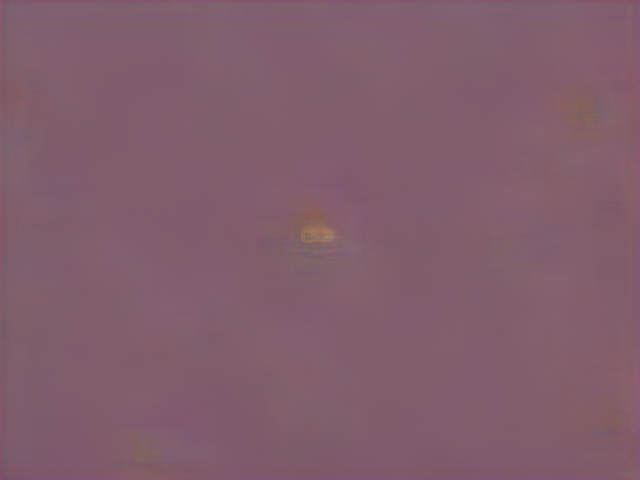

i: 250, loss: 0.777621, losses: 0.777621


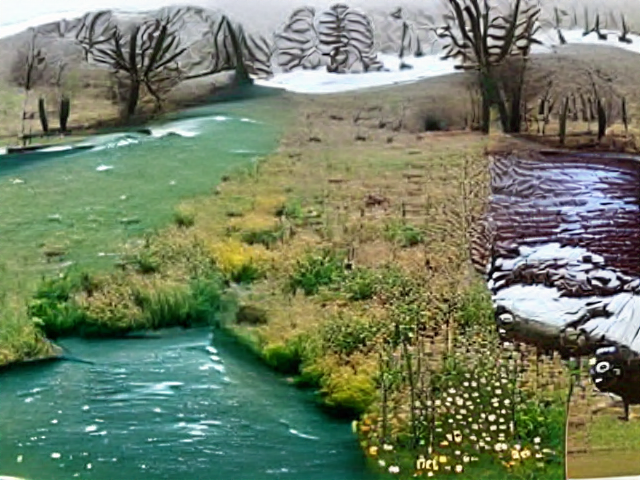

i: 500, loss: 0.736784, losses: 0.736784


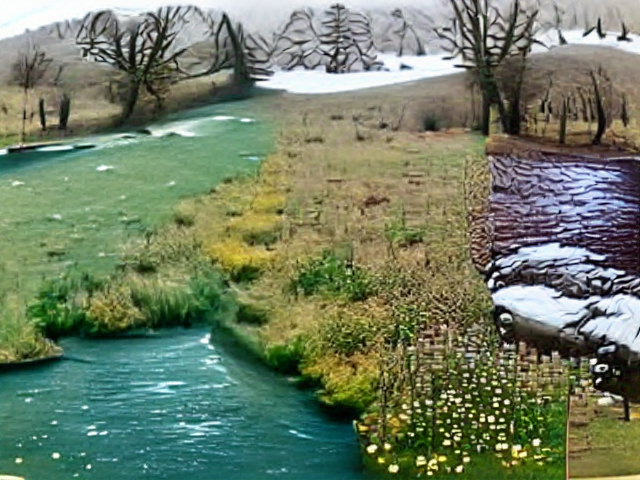

i: 750, loss: 0.740337, losses: 0.740337


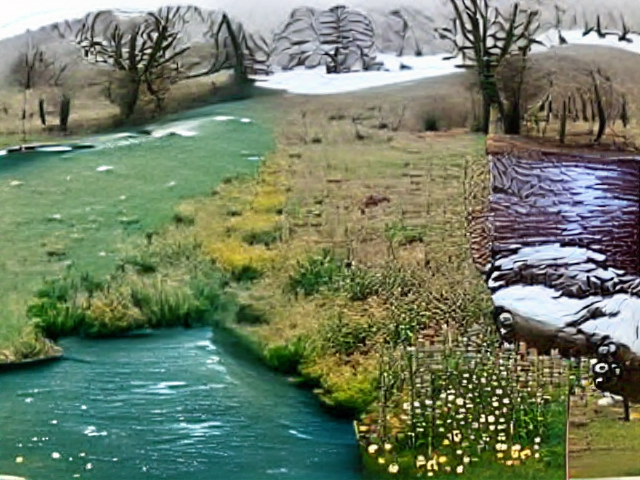

i: 1000, loss: 0.698487, losses: 0.698487


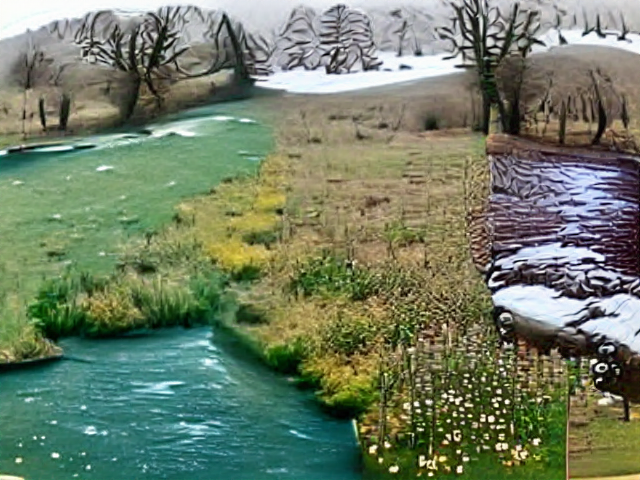

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2465792/45929032 bytes (5.4%)6660096/45929032 bytes (14.5%)10821632/45929032 bytes (23.6%)14991360/45929032 bytes (32.6%)19136512/45929032 bytes (41.7%)23166976/45929032 bytes (50.4%)27336704/45929032 bytes (59.5%)31424512/45929032 bytes (68.4%)35307520/45929032 bytes (76.9%)39403520/45929032 bytes (85.8%)43425792/45929032 bytes (94.5%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Downloading...
From: https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene
To: /root/.ml4a/ESRGAN/RRDB_ESRGAN_x4.pth
100%|██████████| 66.9M/66.9M [00:01<00:00, 60.8MB/s]


upsampled 4x


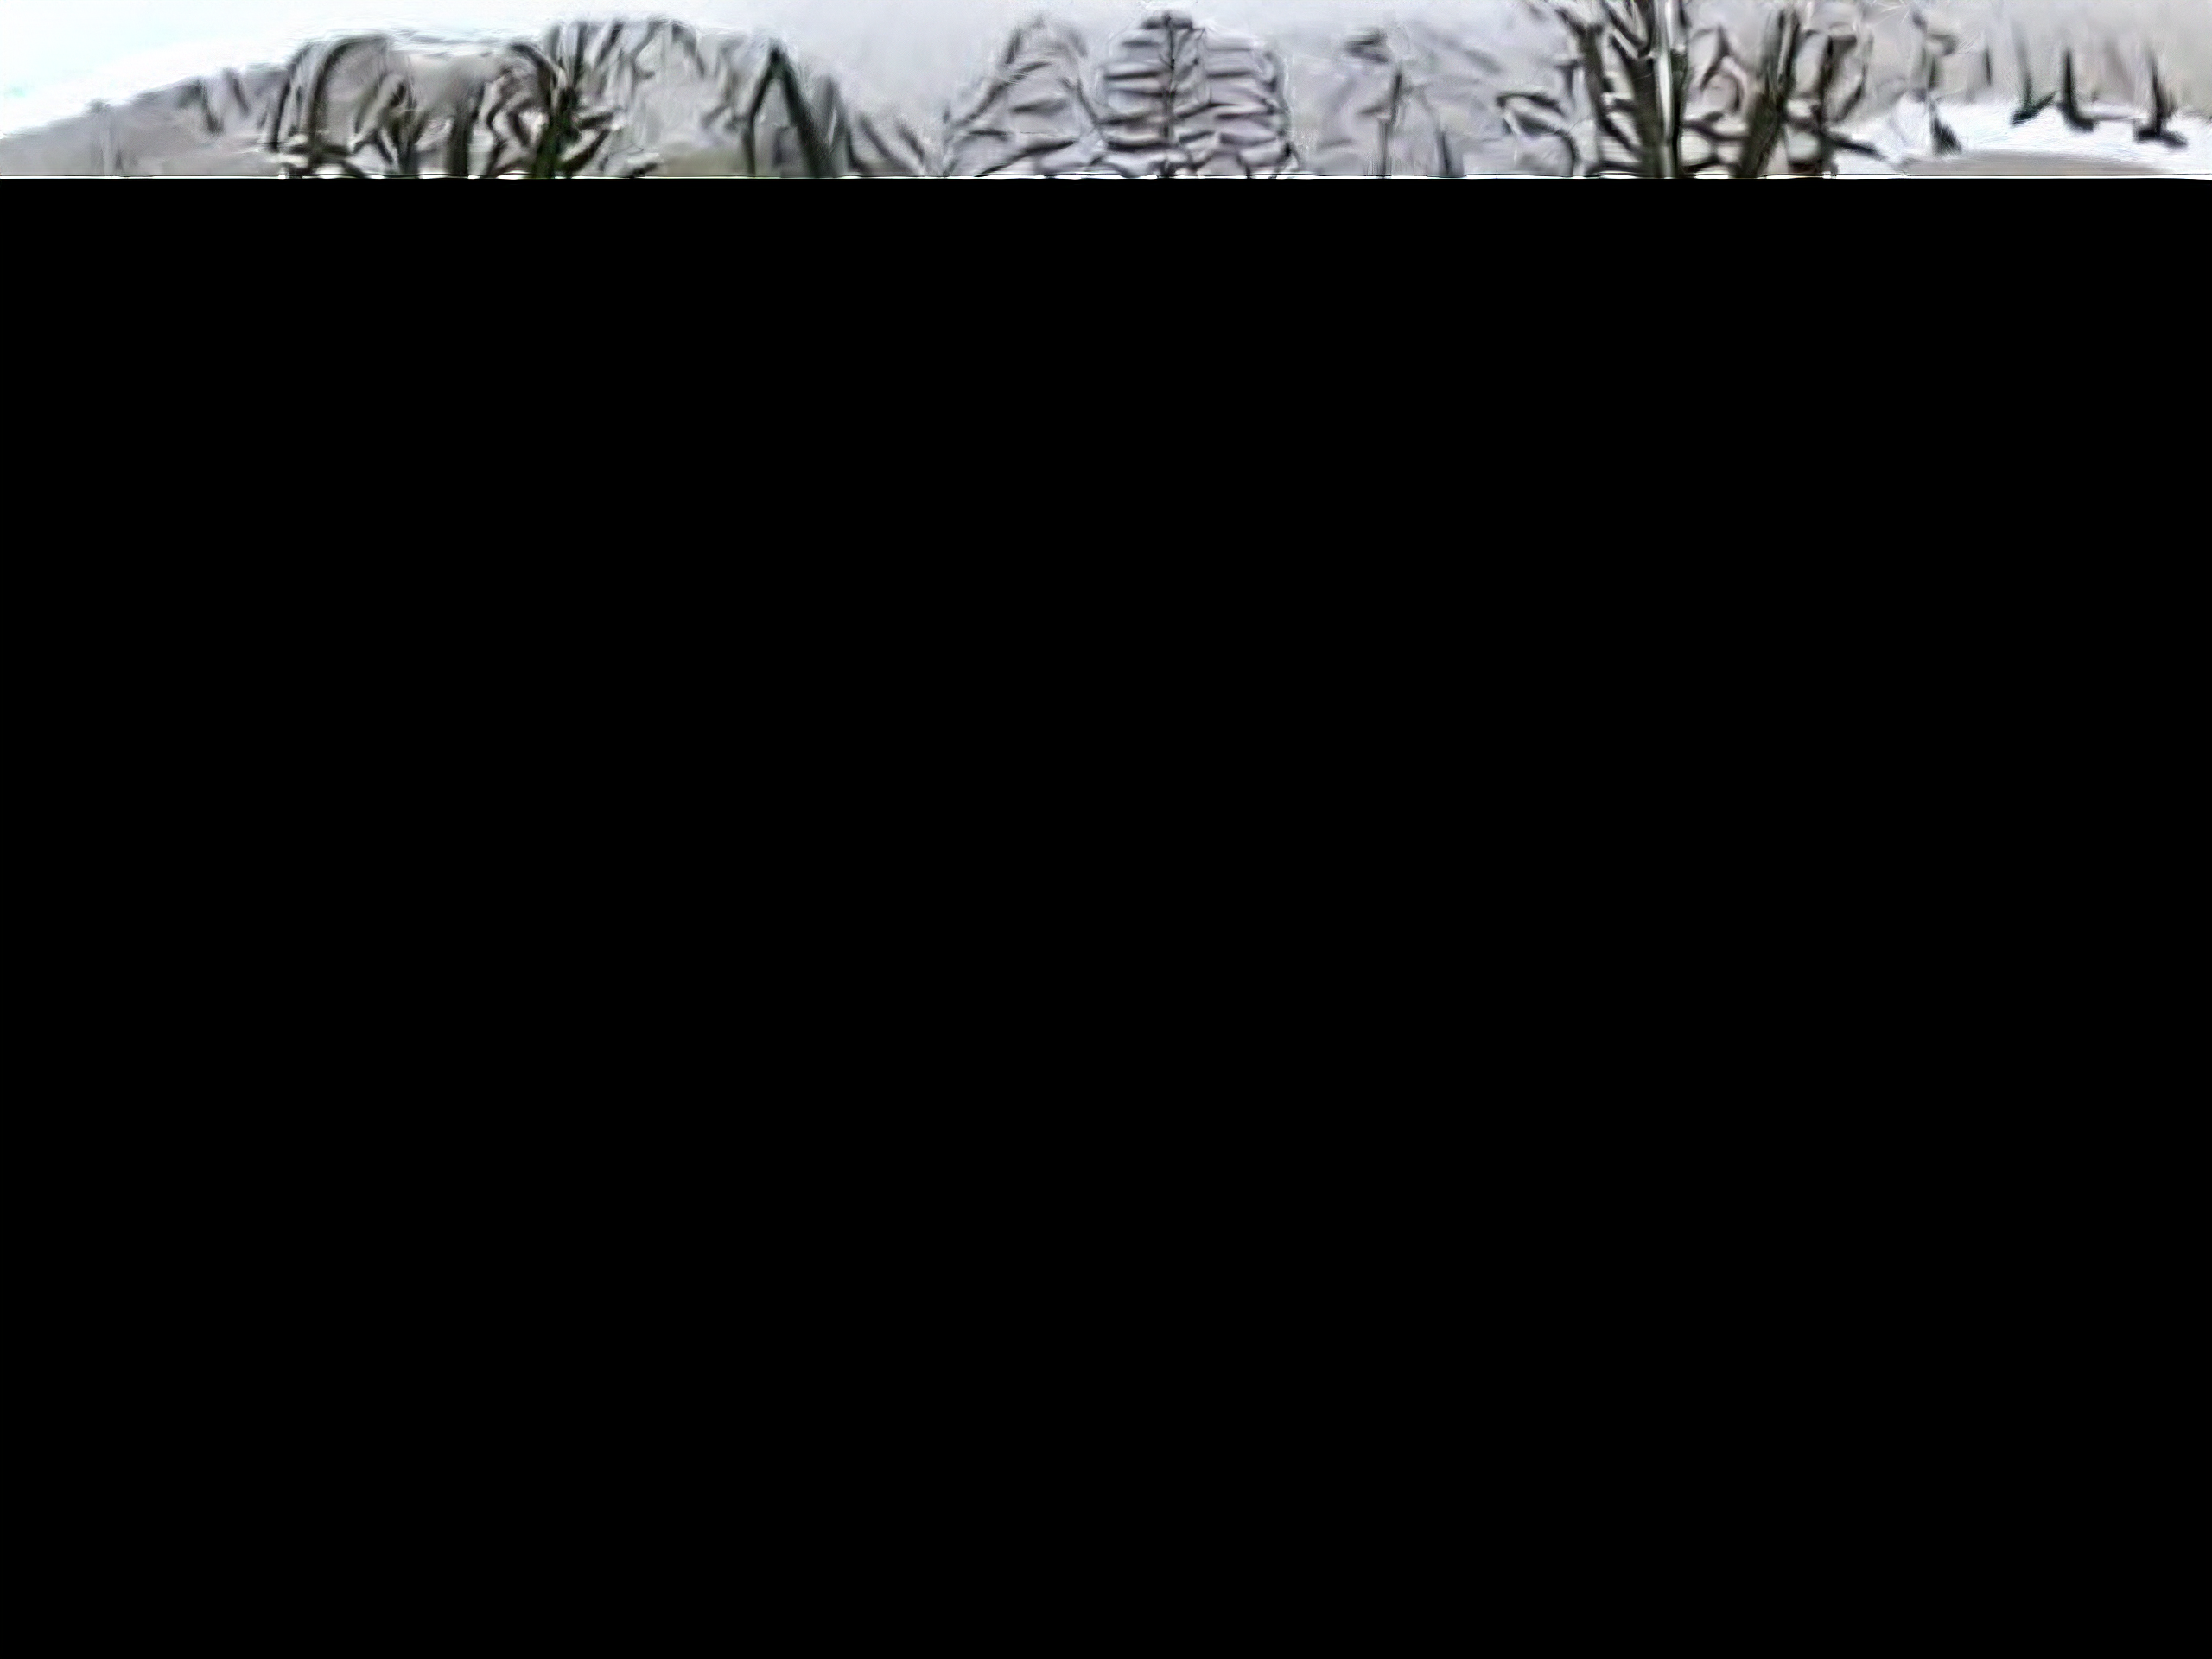

In [ ]:
#@title Start AI Image Generation!
name_model = model_name
!rm -rf steps
!mkdir steps

metadata = PngInfo()
for k, v in gen_config.items():
    try:
        metadata.add_text("AI_ " + k, str(v))
    except UnicodeEncodeError:
        pass

if init_image_icon or target_image_icon:
  for k, v in icon_config.items():
    try:
        metadata.add_text("AI_Icon_ " + k, str(v))
    except UnicodeEncodeError:
        pass

#model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
#                "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
#name_model = model_names[model_name]     

if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    model_target_images = []
else:
    model_target_images = target_images.split("|")
    model_target_images = [image.strip() for image in model_target_images]

model_texts = [phrase.strip() for phrase in texts.split("|")]
if model_texts == ['']:
    model_texts = []


args = argparse.Namespace(
    prompts=model_texts,
    image_prompts=model_target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model_name}.yaml',
    vqgan_checkpoint=f'{model_name}.ckpt',
    step_size=step_size,
    cutn=cutn,
    cut_pow=cut_pow,
    display_freq=images_interval,
    seed=seed,
)
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if model_texts:
    print('Using texts:', model_texts)
if model_target_images:
    print('Using image prompts:', model_target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
# clock=deepcopy(perceptor.visual.positional_embedding.data)
# perceptor.visual.positional_embedding.data = clock/clock.max()
# perceptor.visual.positional_embedding.data=clamp_with_grad(clock,0,1)

cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

if name_model == 'gumbel_8192':
  e_dim = 256
  n_toks = model.quantize.n_embed
  z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
  z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
# z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
# z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

# normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                            std=[0.229, 0.224, 0.225])

if args.init_image:
    if 'http' in args.init_image:
        img = Image.open(urlopen(args.init_image))
    else:
        img = Image.open(args.init_image)
    pil_image = img.convert('RGB')
    if pil_image.size != (width, height):
      print(f"Resizing source image to {width}x{height}")
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    pil_tensor = TF.to_tensor(pil_image)
    z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    # z = one_hot @ model.quantize.embedding.weight
    if name_model == 'gumbel_8192':
      z = one_hot @ model.quantize.embed.weight
    else:
      z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)
scheduler = StepLR(opt, step_size=5, gamma=0.95)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                std=[0.26862954, 0.26130258, 0.27577711])



pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = Image.open(path)
    pil_image = img.convert('RGB')
    img = resize_image(pil_image, (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if name_model == 'gumbel_8192':
      z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
      z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png', pnginfo=metadata)
    display.display(display.Image('progress.png'))

def ascend_txt():
    # global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []

    if args.init_weight:
        # result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    img = Image.fromarray(img)
    # imageio.imwrite(f'./steps/{i:03d}.png', np.array(img))

    img.save(f"./steps/{i:03d}.png", pnginfo=metadata)
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    scheduler.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

try:
    for i in tqdm(range(max_steps)):
          train(i)
    checkin(max_steps, ascend_txt())
except KeyboardInterrupt:
    pass

## now we build HD
from ml4a import image
from ml4a.models import esrgan

img1 = f"./steps/{i:03d}.png"
img2 = esrgan.run(img1)

image.display(img2, title="upsampled 4x")


You can right-click the final image and Save As to save it locally, Copy and Paste it directly to another application/social media site, or go into the `/steps/` folder to view all genenerate images for each step.

If you do use these images, please note that they were created by VQGAN + CLIP and/or provide a link to this Notebook so others can make their own images too!

## Generate Video

You can generate and download a video of the AI generation you just did by running the following cell! 

In [ ]:
frame_rate = 30 #@param {type:"number"}

print("Rendering Video...")
result = os.system(f"ffmpeg -y -r {frame_rate} -i /content/steps/%03d.png -c:v libx264 -vf fps={frame_rate} -pix_fmt yuv420p /content/vqgan_clip.mp4")
print("Video saved at vqgan_clip.mp4!")

from google.colab import files
files.download('/content/vqgan_clip.mp4')

Rendering Video...
Video saved at vqgan_clip.mp4!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## License

MIT License

Copyright (c) 2021 Ray Krehn

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

Copyright (c) 2021 Katherine Crowson

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.